###**1.** **Import Library yang Dibutuhkan**

Pada bagian ini, seluruh library yang diperlukan untuk analisis RFM dan clustering dimuat.
Library yang digunakan mencakup:

*   **Pandas & Nmpy** → untuk manipulasi data
*   **Datetime** → untuk pengolahan tanggal
*   **Matplotlib & Seaborn** → untuk visualisasi dasar
*   **Scikit-learn** → untuk scaling, clustering, dan evaluasi
*   **Plotly** → untuk visualisasi interaktif
*   **StandardScaler, KMeans, Silhouette_score** → untuk proses clustering dan evaluasi kualitas klaster.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

###**2.** **Memuat Dataset**

Pada tahap ini, dataset **Online Retail** dimuat dari file `online_retail.csv `menggunakan **Pandas**.

Dataset ini berisi transaksi pelanggan yang akan digunakan untuk melakukan analisis **RFM (Recency, Frequency, Monetary) dan Clustering**.


*   `encoding='latin-1'` digunakan untuk mencegah error karakter khusus yang sering muncul pada dataset transaksi.
*   `data.head()` digunakan untuk menampilkan 5 baris pertama sebagai preview struktur data.



In [2]:
data = pd.read_csv("online_retail.csv", encoding='latin-1')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


###**3. Menampilkan Informasi Dataset**

Pada tahap ini dilakukan pengecekan struktur awal dataset untuk memahami bentuk dan isi data sebelum dilakukan preprocessing.

*   `data.columns.tolist()` → menampilkan daftar nama kolom dalam dataset.
*   `data.shape` → menunjukkan jumlah baris dan kolom (dimensi dataset).

In [3]:
print("Columns:", data.columns.tolist())
print("Shape:", data.shape)

Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']
Shape: (541909, 8)


*   `data.info()` Menampilkan informasi data yang digunakan



In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


*   `data.describe()` Menampilkan ringkasan statistik deskriptif untuk kolom numerik.



In [5]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


#### **4.** **EDA (Exploratory Data Analysis)**

**EDA(Exploratory Data Analysis)** bertujuan memahami struktur data, kualitas data, dan pola awal pada data.

*   Analisis Korelasi Antar Variabel Numerik, digunakan untuk melihat hubungan antar variabel numerik dalam dataset menggunakan matriks korelasi.

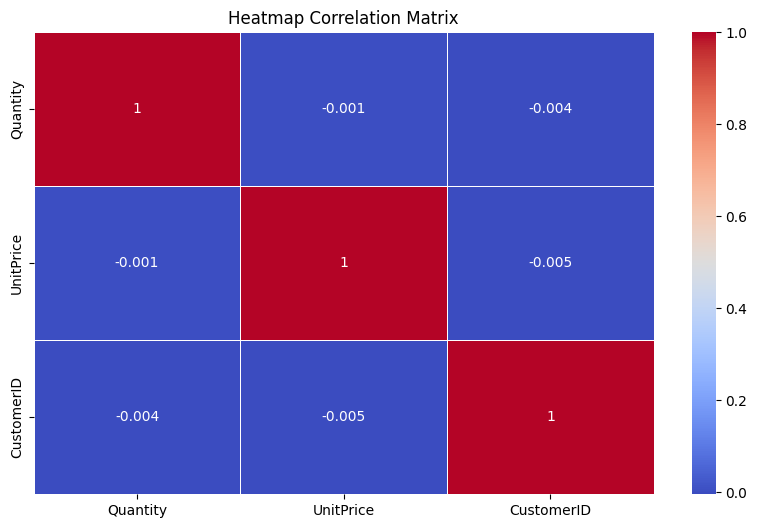

In [6]:
numeric_data = data.select_dtypes(include=['int64', 'float64'])
corr = numeric_data.corr().round(3)
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Heatmap Correlation Matrix")
plt.show()

*   `data.isnull().sum()` Mengecek/Menghitung jumlah nilai kosong (NaN/null) pada setiap kolom.



In [7]:
data.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


###**5.** **Data Cleaning & Preprocessing.**

**Preprocessing** bertujuan membersihkan, memperbaiki, dan menyiapkan data sebelum modeling.

*   Baris tanpa informasi penting seperti `CustomerID` atau `Description` dihapus untuk menjaga kualitas data.



In [8]:
data.dropna(subset=['CustomerID', 'Description'], inplace=True)
data.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


*   Menghapus Kolom `Country` karena tidak diperlukan dalam analisis.



In [9]:
data.drop(columns=['Country'], inplace=True)

*   Mengubah kolom `InvoiceDate` menjadi tipe `datetime`. `errors='coerce'` memastikan bahwa nilai yang tidak dapat dikonversi.



In [10]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], errors='coerce')

*   Menghitung total **nilai transaksi **pada setiap baris data. `TotalAmount` didapat dari mengalikan jumlah barang `(Quantity)` dengan harga satuan `(UnitPrice)`.



In [11]:
data['TotalAmount'] = data['Quantity'] * data['UnitPrice']

*   Menghapus baris data yang memiliki nilai `Quantity` kurang dari atau sama dengan **0** dan hanya **transaksi** dengan jumlah barang **positif** yang dianggap valid.

In [12]:
data = data[data['Quantity'] > 0]

*   Menampilkan bentuk (jumlah baris dan kolom) data setelah proses **Cleaning**.



In [13]:
print("After cleaning shape:", data.shape)

After cleaning shape: (397924, 8)


###**6. Membangun Model** **RFM(Recency, Frecuency, Monetary)**

*   Menentukan tanggal acuan `(reference date)` untuk perhitungan **Recency** dimana `reference_date` diambil dari tanggal transaksi terakhir + 1 hari,
agar selisih hari **recency** tidak menjadi 0.



In [14]:
reference_date = data['InvoiceDate'].max() + timedelta(days=1)

*   Menghitung nilai **RFM (Recency, Frequency, Monetary)** untuk setiap `CustomerID`.


    1.   **Recency**: selisih hari antara `reference_date` dan tanggal transaksi terakhir pelanggan
    2.   **Frequency**: jumlah transaksi `(InvoiceNo)` yang dilakukan pelanggan
    3.   **Monetary**: total nilai transaksi pelanggan

    `display(rfm.describe())` Menampilkan statistik deskriptif dari data **RFM**






In [15]:
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,   # Recency
    'InvoiceNo': 'count',                                       # Frequency
    'TotalAmount': 'sum'                                        # Monetary
}).reset_index()
display(rfm.describe())

,CustomerID,InvoiceDate,InvoiceNo,TotalAmount
count,4339.000000,4339.000000,4339.000000,4339.000000
mean,15299.936852,92.518322,91.708689,2053.793018
std,1721.889758,100.009747,228.792852,8988.248381
min,12346.000000,1.000000,1.000000,0.000000
25%,13812.500000,18.000000,17.000000,307.245000
50%,15299.000000,51.000000,41.000000,674.450000
75%,16778.500000,142.000000,100.000000,1661.640000
max,18287.000000,374.000000,7847.000000,280206.020000


*   Mengganti nama kolom hasil perhitungan agar sesuai dengan istilah **RFM**:

    1.   `InvoiceDate`  → **Recency**
    2.   `InvoiceNo`    → **Frequency**
    3.   `TotalAmount`  → **Monetary**





In [16]:
rfm.rename(columns={'InvoiceDate': 'Recency',
                    'InvoiceNo': 'Frequency',
                    'TotalAmount': 'Monetary'}, inplace=True)
display(rfm.describe())

,CustomerID,Recency,Frequency,Monetary
count,4339.000000,4339.000000,4339.000000,4339.000000
mean,15299.936852,92.518322,91.708689,2053.793018
std,1721.889758,100.009747,228.792852,8988.248381
min,12346.000000,1.000000,1.000000,0.000000
25%,13812.500000,18.000000,17.000000,307.245000
50%,15299.000000,51.000000,41.000000,674.450000
75%,16778.500000,142.000000,100.000000,1661.640000
max,18287.000000,374.000000,7847.000000,280206.020000


*   Menghitung nilai **kuantil** (`20%, 40%, 60%, 80%`) untuk **Recency**, **Frequency**, dan **Monetary**. **Kuantil** ini digunakan sebagai batas (**threshold**) pemberian **skor RFM**.







In [17]:
quantiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([0.20, 0.40, 0.60, 0.80]).to_dict()

*   `def r_score` → Menerapkan Fungsi **Skor** **Recency** (**R**) untuk memberikan **skor Recency** dimana semakin kecil nilai **Recency** → skor lebih tinggi.

In [18]:
def r_score(x, p, d):
    if x <= d[p][0.20]:
        return 5
    elif x <= d[p][0.40]:
        return 4
    elif x <= d[p][0.60]:
        return 3
    elif x <= d[p][0.80]:
        return 2
    else:
        return 1

*   `def fm_score` → Menerapkan Fungsi **Skor Frequency & Monetary** (**F & M**) untuk memberikan **skor Frequency** dan **Monetary** dimana semakin besar **nilai Frequency/Monetary** → skor lebih tinggi.

In [19]:
def fm_score(x, p, d):
    if x <= d[p][0.20]:
        return 1
    elif x <= d[p][0.40]:
        return 2
    elif x <= d[p][0.60]:
        return 3
    elif x <= d[p][0.80]:
        return 4
    else:
        return 5

*   Menerapkan **Skor RFM ke Data** dengan dihitung berdasarkan **kuantil**.

In [20]:
rfm['R'] = rfm['Recency'].apply(r_score, args=('Recency', quantiles))
rfm['F'] = rfm['Frequency'].apply(fm_score, args=('Frequency', quantiles))
rfm['M'] = rfm['Monetary'].apply(fm_score, args=('Monetary', quantiles))

*   Scaling **RFM Features (Standardization)** Memilih fitur RFM dan menormalkan skalanya agar siap digunakan dalam analisis clustering.


In [21]:
X = rfm[['Recency', 'Frequency', 'Monetary']].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

*   Menentukan jumlah **Cluster** yang optimal dengan **metode Elbow** berdasarkan **nilai inertia** dari hasil **K-Means**.



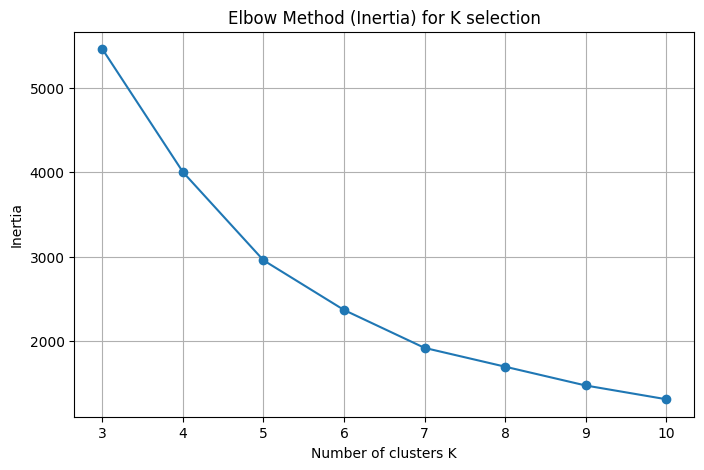

In [22]:
inertia = []
K_range = range(3, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(list(K_range), inertia, marker='o')
plt.xlabel('Number of clusters K')
plt.ylabel('Inertia')
plt.title('Elbow Method (Inertia) for K selection')
plt.grid(True)
plt.show()

*   Menghitung **Silhouette Score** pada berbagai jumlah **cluster** dan menentukan **nilai K terbaik** berdasarkan skor tertinggi.



In [23]:
sil_scores = []
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)
    print(f"K={k} -> Silhouette Score = {sil:.4f}")

best_k = int(K_range[np.argmax(sil_scores)])
print(f"\nBest K silhouette = {best_k} (silhouette = {max(sil_scores):.4f})")

K=3 -> Silhouette Score = 0.6020
K=4 -> Silhouette Score = 0.6011
K=5 -> Silhouette Score = 0.6176
K=6 -> Silhouette Score = 0.5923
K=7 -> Silhouette Score = 0.5243
K=8 -> Silhouette Score = 0.5283
K=9 -> Silhouette Score = 0.5076
K=10 -> Silhouette Score = 0.4255

Best K silhouette = 5 (silhouette = 0.6176)


*   Menerapkan **K-Means** dengan jumlah **cluster** terbaik dan menyimpan hasil pengelompokan pelanggan ke kolom `Cluster` pada **data RFM**.



In [24]:
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(X_scaled)

###**7. Evaluasi Model** **RFM(Recency, Frecuency, Monetary)**
*   Mengevaluasi kualitas hasil **clustering** menggunakan Davies–Bouldin Index dan Calinski–Harabasz Score.



In [25]:
X_eval = X

dbi = davies_bouldin_score(X_eval, rfm['Cluster'])

ch = calinski_harabasz_score(X_eval, rfm['Cluster'])

print("=== Clustering Evaluation Metrics ===")
print(f"Davies–Bouldin Index : {dbi:.4f}")
print(f"Calinski–Harabasz Score : {ch:.4f}")

=== Clustering Evaluation Metrics ===
Davies–Bouldin Index : 1.1437
Calinski–Harabasz Score : 3156.8472


###**8. Mapping Hasil** **Clustering RFM ke Customer Segment**

*   Membuat profil tiap **cluster** dengan menghitung rata-rata nilai **RFM** dan **skor R, F, M** pada setiap **cluster**.



In [26]:
cluster_profile = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'R': 'mean',
    'F': 'mean',
    'M': 'mean'
})

cluster_profile = cluster_profile.round(2)
cluster_profile = cluster_profile.reset_index()

print("\nCluster profile (averages):")
display(cluster_profile)


Cluster profile (averages):


,Cluster,Recency,Frequency,Monetary,R,F,M
0,0,44.26,73.84,1346.98,3.53,3.16,3.19
1,1,249.48,27.79,490.45,1.18,2.01,2.01
2,2,16.08,488.34,12082.72,4.54,4.92,4.94
3,3,2.00,5807.75,70925.29,5.00,5.00,5.00
4,4,7.67,827.83,190863.46,4.83,4.33,5.00


*   Memberi nama **segmen** pada setiap **cluster** berdasarkan aturan **nilai Recency, Frequency, dan Monetary.**




In [27]:
def map_cluster_to_name(row):
    r = row['Recency']
    f = row['Frequency']
    m = row['Monetary']

    if r <= 10 and f >= 800 and m >= 100000:
        return "Big Spenders"

    if r <= 15 and f >= 1000 and m >= 50000:
        return "Champions"

    if r <= 25 and f >= 300 and m >= 10000:
        return "Loyalists"

    if r <= 50 and f <= 100 and m <= 5000:
        return "Regular"

    if r >= 100 and f <= 50 and m <= 1000:
        return "At-Risk"

cluster_profile['SegmentName'] = cluster_profile.apply(map_cluster_to_name, axis=1)

display(cluster_profile[['Cluster','Recency','Frequency','Monetary','SegmentName']])

,Cluster,Recency,Frequency,Monetary,SegmentName
0,0,44.26,73.84,1346.98,Regular
1,1,249.48,27.79,490.45,At-Risk
2,2,16.08,488.34,12082.72,Loyalists
3,3,2.00,5807.75,70925.29,Champions
4,4,7.67,827.83,190863.46,Big Spenders


###**9. Integrasi Hasil Segmentasi ke Data**

*   Memberi label **segmen** pada seluruh data pelanggan yang ada di data, dan contoh hasilnya menampilkan ***10 data pertama*** sebagai sampel.



In [28]:
segment_map = cluster_profile.set_index('Cluster')['SegmentName'].to_dict()
rfm['ClusterSegmentName'] = rfm['Cluster'].map(segment_map)

print("\nRFM sample with cluster & labels:")
display(rfm.head(10))


RFM sample with cluster & labels:


,CustomerID,Recency,Frequency,Monetary,R,F,M,Cluster,ClusterSegmentName
0,12346.0,326,1,77183.60,1,1,5,2,Loyalists
1,12347.0,2,182,4310.00,5,5,5,0,Regular
2,12348.0,75,31,1797.24,2,3,4,0,Regular
3,12349.0,19,73,1757.55,4,4,4,0,Regular
4,12350.0,310,17,334.40,1,2,2,1,At-Risk
5,12352.0,36,85,2506.04,3,4,5,0,Regular
6,12353.0,204,4,89.00,1,1,1,1,At-Risk
7,12354.0,232,58,1079.40,1,3,4,1,At-Risk
8,12355.0,214,13,459.40,1,1,2,1,At-Risk
9,12356.0,23,59,2811.43,4,4,5,0,Regular


###**10. Visualisasi dan Analisis Distribusi Segmentasi**

*   Menghitung **rata-rata nilai Recency, Frequency, dan Monetary** pada tiap cluster, lalu menampilkannya dalam bentuk **heatmap** untuk membandingkan karakteristik antar **cluster**.



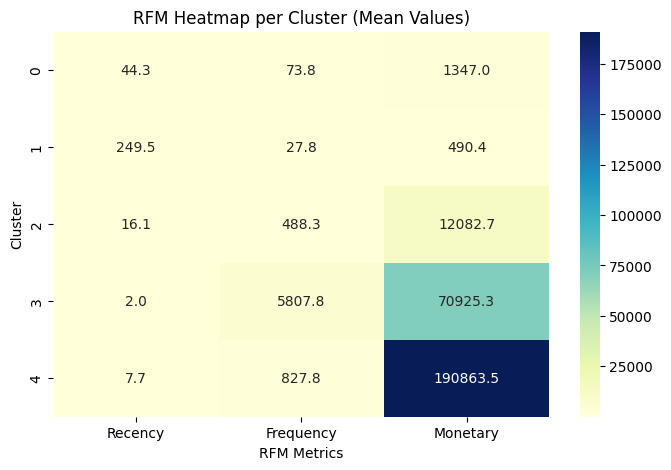

In [29]:
rfm_heatmap = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

plt.figure(figsize=(8, 5))
sns.heatmap(
    rfm_heatmap.set_index('Cluster'),
    annot=True,
    cmap='YlGnBu',
    fmt='.1f'
)
plt.title('RFM Heatmap per Cluster (Mean Values)')
plt.ylabel('Cluster')
plt.xlabel('RFM Metrics')
plt.show()

*   Membuat **visualisasi scatter** 2D antara **Recency dan Frequency** untuk seluruh data pelanggan.


In [30]:
fig = px.scatter(
    rfm,
    x='Recency',
    y='Frequency',
    color='Cluster',
    hover_data=['CustomerID','Recency','Frequency','Monetary','R','F','M'],
    title=f'2D Scatter RFM (Recency vs Frequency) by Cluster (K={best_k})'
)
fig.show()

*   Menghitung jumlah pelanggan pada setiap segmen dan menampilkannya dalam bentuk **grafik batang** untuk melihat **distribusi pelanggan per segmen**.



In [31]:
seg_counts = rfm['ClusterSegmentName'].value_counts().reset_index()
seg_counts.columns = ['SegmentName','Count']
fig2 = px.bar(seg_counts, x='SegmentName', y='Count', title='Customers per Mapped Segment', text='Count')
fig2.update_layout(xaxis_title='Segment', yaxis_title='Count', xaxis_tickangle=-45)
fig2.show()

###**INTERPRETASI DAN INSIGHT PEMASARAN UNTUK SETIAP SEGMENT**

##**1. Regula**r

Pelanggan yang berbelanja cukup rutin dengan nilai dan frekuensi yang sedang.

Rekomendasi Strategi:

*   Berikan **Diskon** pembelian **10%**
*   Buat **Bundle Hemat**
*   Berikan rekomendasi **Produk Populer** atau produk **best seller**
*   Gunakan **push-notification** atau **email rutin** ketika ada diskon/produk baru

##**2. At-Risk**

Pelanggan yang sudah lama tidak berbelanja dan berpotensi berhenti(**Churn**).

Rekomendasi Strategi:

*   Berikan **Win-Back Voucher 40%** dimana pelanggan yang kembali berbelanja akan mendapatkan **diskon 40%**  produk tertentu untuk memicu comeback.
*   Kirim **Email "We Miss You"** yaitu **pesan personal** agar pelanggan merasa diperhatikan
*   Kirim **survey** kenapa tidak kembali dimana hal ini menunjukkan bahwa **feedback** pelanggan penting untuk peningkatan **layanan**.
*   Berikan **Time sensitive offer** yaitu memberikan **diskon** dengan batas waktu tertentu untuk menciptakan urgensi
  
##**3. Loyal Customer (Loyalists)**

Pelanggan aktif yang sering berbelanja dan memberikan nilai cukup besar.

Rekomendasi Strategi:

*   Berikan **reward points** yaitu **poin apresiasi** yang dapat ditukarkan dengan **voucher** atau **produk** pilihan
*   Berikan **Diskon repeat purchase** yaitu **diskon khusus** untuk pembelian berikutnya untuk mendorong transaksi berulang.
*   Kirimkan **personalized recommendations** yaitu **menawarkan** rekomendasi produk yang sesuai riwayat belanja dan preferensi pelanggan.
*   Berikan akses **promo early bird** yaitu **akses promo** lebih cepat dibanding pelanggan lain.

##**4. Champions**

Pelanggan paling aktif dengan kontribusi belanja sangat tinggi.

Rekomendasi Strategi:

*   Berikan **loyalty premium** yaitu **keistimewaan eksklusif** seperti **diskon** lebih besar atau **layanan prioritas**.
*   Tawarkan **bundle produk dengan nilai tinggi**
*   Kirim produk berdasarkan **frequent purchase** yaitu produk yang sering mereka beli secara berkala, sehingga proses **belanja lebih mudah dan cepat.**
*   Ajak ke **program komunitas** atau **review produk** yaitu pelanggan ikut program komunitas atau memberikan ulasan untuk meningkatkan keterlibatan.

##**5. Big Spenders**

Pelanggan dengan nilai belanja sangat besar meski tidak seaktif Champions.

Rekomendasi Strategi:

*   Berikan **VIP membership** (prioritas layanan, penawaran eksklusif)
*   **Personalized offer** **produk eksklusif** yang dikurasi berdasarkan preferensi dan riwayat belanja.
*   **Early access** ke koleksi/produk baru atau limited edition yaitu memberikan **akses lebih awal** ke koleksi/produk baru atau edisi terbatas sebelum rilis umum.
*   **Kirim gift** pada ulang tahun atau momen penting